In [1]:
import numpy as np
import subprocess
import tqdm
import pandas as pd

import os
import os.path as osp





import h5py
import uproot

import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

import awkward as ak
import random

In [2]:
lte_path = "/vols/cms/mm1221/Data/mix/train/raw/18k.root"

In [3]:
import uproot
import matplotlib.pyplot as plt

# Open files
data= uproot.open(lte_path)

In [26]:
print(data.keys())

['tracksters;4', 'tracksters;3', 'clusters;12', 'clusters;11', 'candidates;1', 'trackstersMerged;5', 'trackstersMerged;4', 'associations;3', 'associations;2', 'simtrackstersSC;11', 'simtrackstersSC;10', 'simtrackstersCP;11', 'simtrackstersCP;10', 'tracks;1', 'simTICLCandidate;1']


In [10]:
v_eta = data['clusters']['position_eta'].array()
v_phi = data['clusters']['position_phi'].array()

In [19]:
v_id = data['clusters']['cluster_type'].array()

In [18]:
print(v_id.keys())

['seedID', 'energy', 'correctedEnergy', 'correctedEnergyUncertainty', 'position_x', 'position_y', 'position_z', 'position_eta', 'position_phi', 'cluster_layer_id', 'cluster_type', 'cluster_time', 'cluster_timeErr', 'cluster_number_of_hits']


In [25]:
print(np.unique(v_id[0]))

[0, 1, 2, 5, 6]


In [4]:
energy_lte = data['simtrackstersCP;11']['regressed_energy'].array()


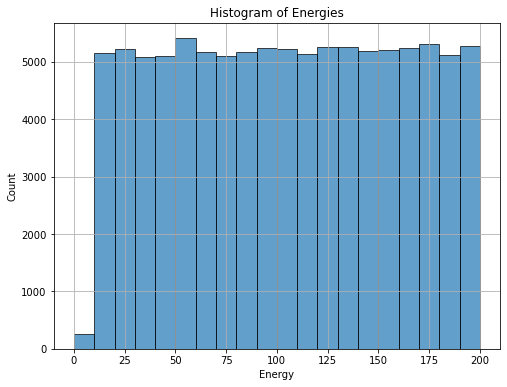

In [5]:
# Flatten the list of lists into a single list
all_energies_lte = [e for event in energy_lte for e in event]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(all_energies_lte, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Energy")
plt.ylabel("Count")
plt.title("Histogram of Energies")

plt.grid(True)


--- η Range ---
Min η: 1.5919
Max η: 5.1831
η Range: 3.5912
-----------------------------


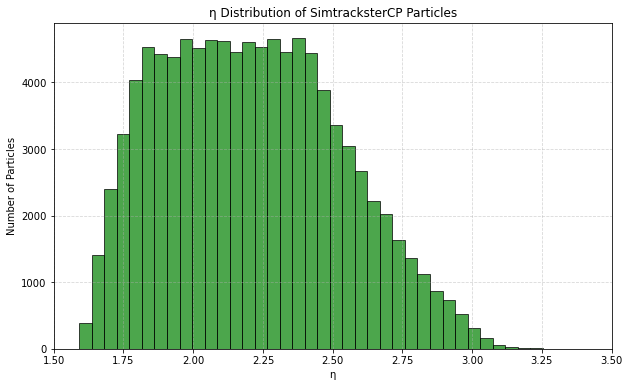

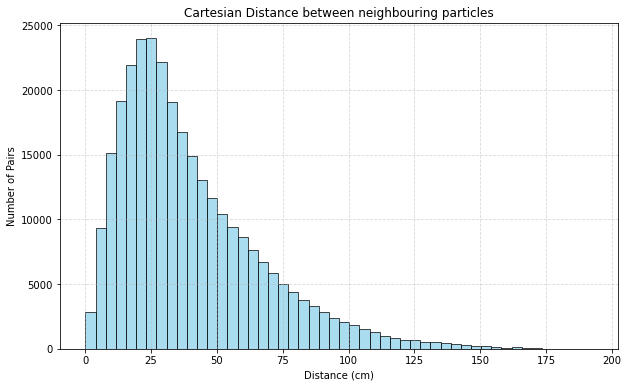

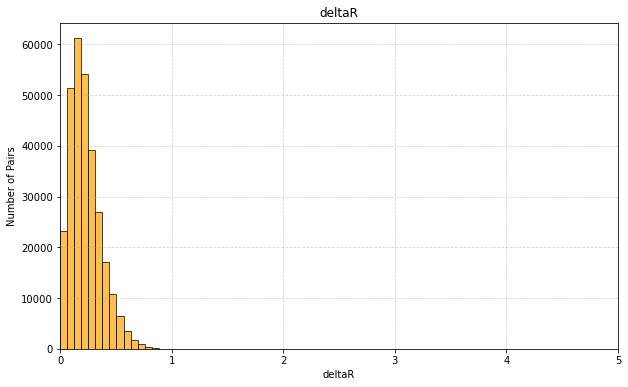


--- Cartesian Distance Between Neighboring SimtracksterCP Particles Statistics ---
Mean: 39.8714
Median: 32.8820
Standard Deviation: 26.9159
Min: 0.0700
Max: 192.7480
-----------------------------

--- ΔR Distance Between Neighboring SimtracksterCP Particles Statistics ---
Mean: 0.2284
Median: 0.2031
Standard Deviation: 0.1402
Min: 0.0001
Max: 3.1588
-----------------------------


In [8]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import math


simtracksterCP_branch = data["simtrackstersCP;11"]

# Extract barycenter positions and angular information
barycenter_x = simtracksterCP_branch["barycenter_x"].array(library="np")
barycenter_y = simtracksterCP_branch["barycenter_y"].array(library="np")
barycenter_z = simtracksterCP_branch["barycenter_z"].array(library="np")
barycenter_eta = simtracksterCP_branch["barycenter_eta"].array(library="np")
barycenter_phi = simtracksterCP_branch["barycenter_phi"].array(library="np")

# --- Eta Range Analysis ---
all_eta = np.concatenate(barycenter_eta)
eta_min = np.min(all_eta)
eta_max = np.max(all_eta)
print(f"\n--- η Range ---")
print(f"Min η: {eta_min:.4f}")
print(f"Max η: {eta_max:.4f}")
print(f"η Range: {eta_max - eta_min:.4f}")
print("-----------------------------")


# --- Calculate Separation Between Neighboring SimtracksterCP Particles ---
def delta_phi(phi1, phi2):
    """Calculate Δφ ensuring it remains in the range [-π, π]."""
    d_phi = phi1 - phi2
    while d_phi > np.pi:
        d_phi -= 2 * np.pi
    while d_phi < -np.pi:
        d_phi += 2 * np.pi
    return d_phi

def calculate_distances(x, y, z, eta, phi):
    cartesian_distances = []
    deltaR_distances = []
    
    for event_x, event_y, event_z, event_eta, event_phi in zip(x, y, z, eta, phi):
        # Pairwise combinations of particles in the same event
        for (x1, y1, z1, eta1, phi1), (x2, y2, z2, eta2, phi2) in combinations(
            zip(event_x, event_y, event_z, event_eta, event_phi), 2
        ):
            # Cartesian distance
            d_cartesian = np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
            cartesian_distances.append(d_cartesian)
            
            # ΔR distance
            d_eta = eta1 - eta2
            d_phi = delta_phi(phi1, phi2)
            d_deltaR = np.sqrt(d_eta**2 + d_phi**2)
            deltaR_distances.append(d_deltaR)
    
    return cartesian_distances, deltaR_distances

# Calculate distances
cartesian_distances, deltaR_distances = calculate_distances(
    barycenter_x, barycenter_y, barycenter_z, barycenter_eta, barycenter_phi
)

# --- Plot Histograms ---
def plot_histogram(data, title, xlabel, ylabel, bins=50, color='blue', xlim=None):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, edgecolor='black', alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    if xlim:
        plt.xlim(xlim)
    plt.show()



# --- Plot η Distribution ---
plot_histogram(
    all_eta,
    title="η Distribution of SimtracksterCP Particles",
    xlabel="η",
    ylabel="Number of Particles",
    color='green',
    bins=80,
    xlim=(1.5, 3.5)
)
# Plot Cartesian Distance Histogram
plot_histogram(
    cartesian_distances,
    title="Cartesian Distance between neighbouring particles",
    xlabel="Distance (cm)",
    ylabel="Number of Pairs",
    color='skyblue'
)

# Plot ΔR Distance Histogram
plot_histogram(
    deltaR_distances,
    title="deltaR",
    xlabel="deltaR",
    ylabel="Number of Pairs",
    color='orange',
    xlim=(0, 5)  # Common ΔR range
)

# --- Statistical Analysis ---
def print_statistics(data, name):
    print(f"\n--- {name} Statistics ---")
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Median: {np.median(data):.4f}")
    print(f"Standard Deviation: {np.std(data):.4f}")
    print(f"Min: {np.min(data):.4f}")
    print(f"Max: {np.max(data):.4f}")
    print("-----------------------------")

print_statistics(cartesian_distances, "Cartesian Distance Between Neighboring SimtracksterCP Particles")
print_statistics(deltaR_distances, "ΔR Distance Between Neighboring SimtracksterCP Particles")

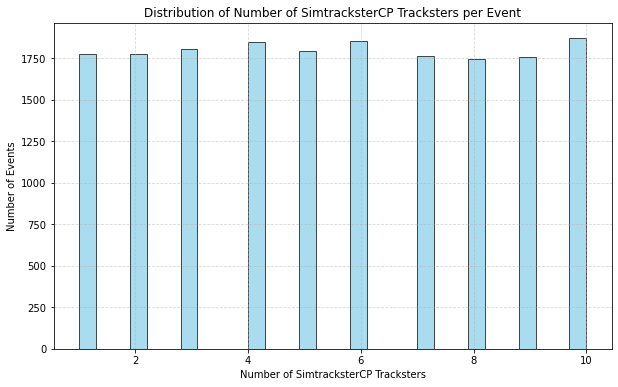

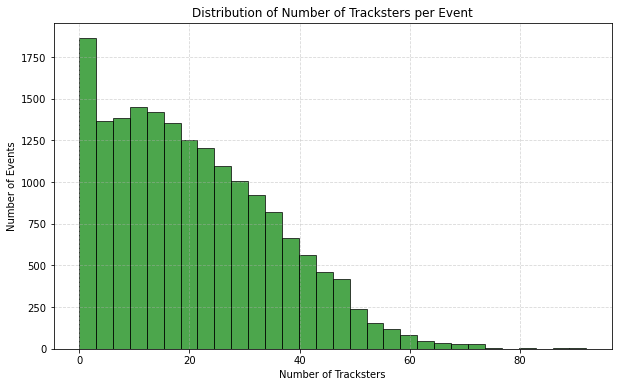

--- SimtracksterCP Tracksters Statistics ---
Mean: 5.51
Median: 5.00
Standard Deviation: 2.87
Min: 1
Max: 10
-----------------------------

--- Tracksters Statistics ---
Mean: 21.11
Median: 19.00
Standard Deviation: 14.61
Min: 0
Max: 92
-----------------------------



In [7]:
import uproot
import uproot
import matplotlib.pyplot as plt
import numpy as np




# Extract data for the keys
# Adjust the branch names if needed after inspecting the exact structure

# 1. simtracksterCP: Number of simtracksterCP tracksters per event
simtracksterCP_branch = data["simtrackstersCP;11"]
num_simtracksterCP = simtracksterCP_branch["NTracksters"].array(library="np")

# 2. tracksters: Number of tracksters per event
tracksters_branch = data["tracksters"]
num_tracksters = tracksters_branch["NTracksters"].array(library="np")

# --- Plotting Histograms ---

# Function to plot histograms
def plot_histogram(data, title, xlabel, ylabel, color='blue'):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, edgecolor='black', alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# 1. Plot simtracksterCP histogram
plot_histogram(
    num_simtracksterCP,
    title="Distribution of Number of SimtracksterCP Tracksters per Event",
    xlabel="Number of SimtracksterCP Tracksters",
    ylabel="Number of Events",
    color='skyblue'
)

# 2. Plot tracksters histogram
plot_histogram(
    num_tracksters,
    title="Distribution of Number of Tracksters per Event",
    xlabel="Number of Tracksters",
    ylabel="Number of Events",
    color='green'
)



# --- Statistical Analysis ---
def print_statistics(data, name):
    print(f"--- {name} Statistics ---")
    print(f"Mean: {np.mean(data):.2f}")
    print(f"Median: {np.median(data):.2f}")
    print(f"Standard Deviation: {np.std(data):.2f}")
    print(f"Min: {np.min(data)}")
    print(f"Max: {np.max(data)}")
    print("-----------------------------\n")

# Print statistics for each dataset
print_statistics(num_simtracksterCP, "SimtracksterCP Tracksters")
print_statistics(num_tracksters, "Tracksters")